# PyQMC 

A user-friendly and flexible implementation of real-space quantum Monte Carlo for molecules and materials. 
Originally created by Will Wheeler from UIUC and Kaiyuan (Vincent) Wu from Rice University to suit the need of the ultracold-atom research project under the supervision of Prof. Kaden Hazzard.

## Advantages
- Integration with notebooks
- Integration with PySCF
- Flexible parallelization
- Full access to objects that are used in the calculation
- Easy to make flexible workflows
- Easy to implement new algorithms and wave functions
- Code is succinct compared to C++ and Fortran codes (7 thousand lines right now)
- Performance is not bad for Python



## Mean-field calculation

The first step is running a mean-field calculation in PySCF to generate a trial function

In [5]:
# PySCF calculation
from pyscf import gto, scf 

mol = gto.M(
    atom="""
            O 0.0000000, 0.000000, 0.00000000
            H 0.761561 , 0.478993, 0.00000000
            H -0.761561, 0.478993, 0.00000000""",
    basis="ccecp-ccpvtz",
    ecp={"O": "ccecp"},
)   
mf = scf.RHF(mol)
mf.chkfile = "h2o_scf.chk"
mf.kernel()

converged SCF energy = -16.9380454509969


-16.938045450996857

## QMC

Once we have the PySCF result, we can use it to run QMC, which typically consists of 
1. optimizing wave function parameters
2. variational Monte Carlo (VMC), computing expectation values of the optimized trial function
3. diffusion Monte Carlo (DMC), a projector method to get closer to the ground state

These can all be run through "recipes" that are included in the code, or "from scratch."

In [1]:
# Optimize QMC wave function
import pyqmc.recipes
pyqmc.recipes.OPTIMIZE("h2o_scf.chk", "h2o_opt.chk", nconfig=2000, linemin_kws={"max_iterations": 1})

default ion_cusp: ['H']
starting warmup
----------vmc done
descent en -17.19336831808914 0.002541530637117239  estimated sigma  1.1366070542984994
descent |grad| 0.036889938794977865


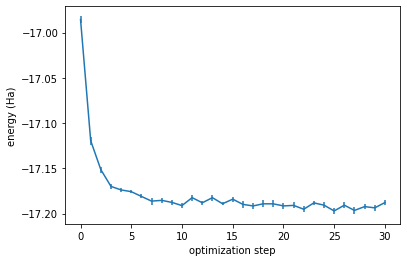

In [100]:
# Check the optimization
import h5py
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("h2o_opt.chk", "r") as hdf:
    d = {k: np.array(hdf[k]) for k in ["energy", "energy_error"]}
    plt.errorbar(np.arange(len(d["energy"])), d["energy"], d["energy_error"], label="h2o_opt")

plt.ylabel("energy (Ha)")
plt.xlabel("optimization step")
plt.show()

In [101]:
with h5py.File("h2o_opt.chk", "r") as hdf:
    print(hdf.keys())

<KeysViewHDF5 ['configs', 'energy', 'energy_error', 'est_min', 'iteration', 'nconfig', 'pgradient', 'tau', 'wf', 'x', 'yfit']>


In [2]:
# Run VMC from optimized wave function
import pyqmc.recipes

accumulators = {"energy": True, "rdm1": True}
# optionally, specify a different set of orbitals (e.g. AOs or only a subset of MOs)
# accumulators["rdm1_options"] = {"orb_coeff": orbitals}
pyqmc.recipes.VMC(
    "h2o_scf.chk",
    "h2o_vmc.chk",
    start_from="h2o_opt.chk",
    accumulators=accumulators,
    vmc_kws={"nblocks": 1, "nsteps_per_block": 10},
    nconfig=1000,
)

default ion_cusp: ['H']
Restarting calculation from step 105
-vmc done


In [103]:
# Run DMC from optimized wave function
accumulators = {"energy": True, "rdm1": True}
pyqmc.recipes.DMC(
    "h2o_scf.chk",
    "h2o_dmc.chk",
    start_from="h2o_opt.chk",
    accumulators=accumulators,
    dmc_kws={"nsteps": 5},
)

default ion_cusp: ['H']
Restarted calculation
energy -17.247894915319048 eref -17.156756973536783 sigma(w) 0.038806513


vmc energy -17.19226100263828 err 0.001025398751400507
dmc energy -17.22577626729874 err 0.0021783362352576965


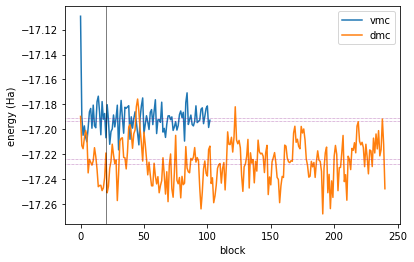

In [5]:
# Check VMC and DMC result, compute error bars
import matplotlib.pyplot as plt
import pyqmc
import h5py
import numpy as np

for method in ["vmc", "dmc"]:
    with h5py.File("h2o_{0}.chk".format(method), "r") as hdf:
        full_energy_array = np.array(hdf["energytotal"])
    warmup = 20
    en = pyqmc.reblock.reblock(full_energy_array[warmup:], 20)
    avg = en.mean()
    err = en.std() / np.sqrt(len(en) - 1)
    print(method + " energy", avg, "err", err)
    
    plt.plot(full_energy_array, label=method)
    plt.axhline(y=avg + err, lw=0.5, ls=":", c="purple")
    plt.axhline(y=avg - err, lw=0.5, ls=":", c="purple")
    
plt.axvline(x=warmup, lw=0.5, c="k")
plt.ylabel("energy (Ha)")
plt.xlabel("block")
plt.legend()

         mean   std err  std err err  nblocks  nsteps_per_block method
0  -17.225817  0.002042     0.000481       10                22    dmc
1  -17.225811  0.002466     0.000551       11                20    dmc
2  -17.225720  0.002551     0.000544       12                18    dmc
3  -17.225796  0.002504     0.000511       13                17    dmc
4  -17.225750  0.002919     0.000572       14                15    dmc
5  -17.225768  0.002489     0.000470       15                14    dmc
6  -17.225776  0.002178     0.000353       20                11    dmc
7  -17.225674  0.001924     0.000218       40                 5    dmc
8  -17.225674  0.001707     0.000157       60                 3    dmc
9  -17.225322  0.001548     0.000123       80                 2    dmc
10 -17.192366  0.000942     0.000222       10                 8    vmc
11 -17.192386  0.000842     0.000188       11                 7    vmc
12 -17.192372  0.000799     0.000170       12                 7    vmc
13 -17

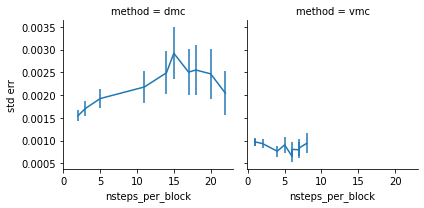

In [9]:
import pyqmc
import pandas as pd
import h5py
import matplotlib.pyplot as plt

df = []    
for method in ["dmc", "vmc"]:
    with h5py.File("h2o_{0}.chk".format(method), "r") as hdf:
        full_energy_array = np.array(hdf["energytotal"])
    warmup = 20

    nblockslist = [10, 11, 12, 13, 14, 15, 20, 40, 60, 80]
    d = pyqmc.reblock.reblock_summary(full_energy_array[warmup:], nblockslist)
    d["method"] = method
    df.append(d)

df = pd.concat(df, axis=0, ignore_index=True)
df = df.rename(columns={"standard error": "std err", "standard error error": "std err err"})
print(df)

import seaborn as sns
g = sns.FacetGrid(data=df, col="method")
g.map(plt.errorbar, "nsteps_per_block", "std err", "std err err")

## Setting up calculation "from scratch"

These recipes are just wrappers for creating a few objects and running the desired function. If you want to customize something, you can use these objects directly, or create your own recipe.

In [12]:
import pyqmc

mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")
wf, to_opt = pyqmc.default_sj(mol, mf) # Slater-Jastrow wave function
configs = pyqmc.initial_guess(mol, nconfig=1000) # walkers
pgrad = pyqmc.gradient_generator(mol, wf, to_opt) # accumulator for parameter gradients

if False:
    pyqmc.line_minimization(wf, configs, pgrad) # optimize wf
    accumulators = {"energy": pgrad.enacc}
    df_vmc, configs = pyqmc.vmc(wf, configs, accumulators=accumulators)
    df_dmc, configs, weights = pyqmc.rundmc(wf, configs, accumulators=accumulators)

Note that `default_jastrow` automatically enforces a nuclear cusp condition if an ecp is not specified for a particular atom. (but you can override it by setting `ion_cusp` to `True`, `False`, or a list of atom names that have cusp conditions)

Also orbital optimization doesn't appear to be working without ecps, so watch out for that.

## Mixed estimator extrapolation (NOT THAT RELEVANT TO VINCENT WU)

DMC projects the trial function onto the ground state, but samples the "mixed distribution", the overlap of the trial function and projected function. When averaging operators that do not commute with the Hamiltonian (e.g. density matrices), this leads to a "mixed estimator error", which can be corrected by adding the difference between the DMC and VMC values.

The mixed estimator extrapolation is straightforward from the VMC and DMC output files.

In [22]:
# Mixed estimator extrapolation of 1RDM
import h5py
import numpy as np
import pyqmc

# Load data
warmup = 40
obdm = {}
for method in ["vmc", "dmc"]:
    with h5py.File(f"h2o_{method}.chk", "r") as hdf:
        # Extract data from hdf
        value = np.array(hdf["rdm1value"])
        norm = np.array(hdf["rdm1norm"])
        # Exclude warmup and reblock
        value = pyqmc.reblock.reblock(value[warmup:], 20)
        norm = pyqmc.reblock.reblock(norm[warmup:], 20)
        # Normalize one-body distribution
        print("norm err should be small", method, norm.std() / np.sqrt(len(norm) - 1))
        obdm[method] = pyqmc.obdm.normalize_obdm(value, norm.mean(axis=0))

# Extrapolate
extrap = 2 * obdm["dmc"].mean(axis=0) - obdm["vmc"].mean(axis=0)
err = {m: obdm[m].std(axis=0) / np.sqrt(len(obdm[m]) - 1) for m in ["vmc", "dmc"]}
extrap_err = np.sqrt(err["dmc"] ** 2 + err["vmc"] ** 2)


norm err should be small vmc 1.110308283659344e-05
norm err should be small dmc 1.068883790988038e-05


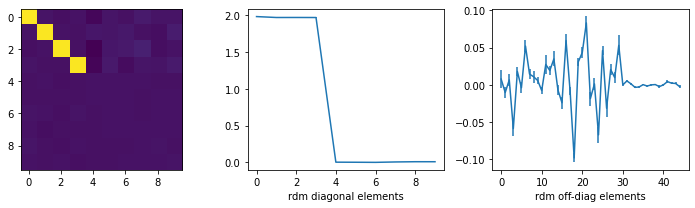

In [33]:
# Plot density matrix
import matplotlib.pyplot as plt
import numpy as np

norb = 10
rdm1 = extrap[:norb, :norb]
rdm1_err = extrap_err[:norb, :norb]

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(extrap[:10, :10])

axs[1].errorbar(np.arange(rdm1.shape[0]), np.diag(rdm1), np.diag(rdm1_err))
axs[1].set_xlabel("rdm diagonal elements")

triu_inds = np.triu_indices(norb, k=1)
axs[2].errorbar(np.arange(len(triu_inds[0])), rdm1[triu_inds], rdm1_err[triu_inds])
axs[2].set_xlabel("rdm off-diag elements")

plt.tight_layout()

## Using PySCF tools

We can take advantage of existing PySCF tools for plotting density

Text(0.5, 1.0, 'H2O density')

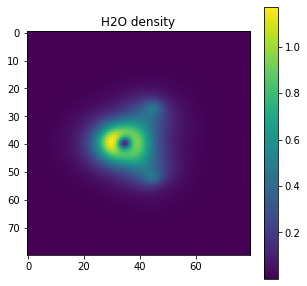

In [50]:
# Use PySCF for plotting density
from pyscf.tools import cubegen
import pyqmc
import numpy as np

mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")
orbitals = mf.mo_coeff # these are the default RDM orbitals used in the recipes
rdm1_ao = np.linalg.multi_dot([orbitals, extrap, orbitals.T])
cube = cubegen.density(mol, "h2o_extrap_den.cube", rdm1_ao)

# Plot slice through z=0
import matplotlib.pyplot as plt
z0 = int(cube.shape[-1] / 2)
plt.figure(figsize=(5,5))
im = plt.imshow(cube[:, :, z0])
plt.colorbar(im)
plt.title("H2O density")

## Custom accumulators

To calculate quantities that are not already implemented, it's easy to write new accumulator objects.

In [80]:
# Define the accumulator
import numpy as np

class NumberDistributionAccumulator:
    def __init__(self, is_in_region, max_n=20):
        self.max_n = max_n
        self.is_in_region = is_in_region

    def __call__(self, configs, wf):
        in_region = self.is_in_region(configs)
        n = np.sum(in_region, axis=1)
        nwalkers = configs.configs.shape[0]
        dist = np.zeros((nwalkers, self.max_n + 1))
        dist[np.arange(len(n)), n] = 1 
        return {"region": dist}

    def avg(self, configs, wf):
        return {k: np.mean(v, axis=0) for k, v in self(configs, wf).items()}

In [81]:
# Define some counting functions to give to the accumulator
import numpy as np

def is_near_O(configs):
    return configs.configs[:, :, 1] < 0.4526 # y-coord of H in Bohr

class IsInSphere:
    def __init__(self, center, r):
        self.center = np.asarray(center)
        self.r = r
        
    def __call__(self, configs):
        d = configs.dist.dist_i(self.center, configs.configs)
        return np.linalg.norm(d, axis=-1)[:, :, 0].T < self.r

In [82]:
# Use number distribution accumulator on optimized wf in VMC
import pyqmc

mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")
wf, to_opt = pyqmc.default_sj(mol, mf)
pyqmc.read_wf(wf, "h2o_opt.chk")

acc = {}
acc["onumber"] = NumberDistributionAccumulator(is_near_O, max_n=8)
Hcoord = mol.atom_coords()[1]
r = np.linalg.norm(Hcoord) / 2
acc["osphere"] = NumberDistributionAccumulator(IsInSphere((0, 0, 0), r), max_n=8)
acc["hsphere"] = NumberDistributionAccumulator(IsInSphere(Hcoord, r), max_n=8)

df, configs = pyqmc.vmc(wf, configs, accumulators=acc, nblocks=800, hdf_file="h2o_vmc_numberacc.chk", verbose=True)

default ion_cusp: ['H']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------vmc done


The function `read_wf` loads the parameter dictionary from the file (e.g. the output of `line_minimization`/`OPTIMIZE`) into the object passed in.

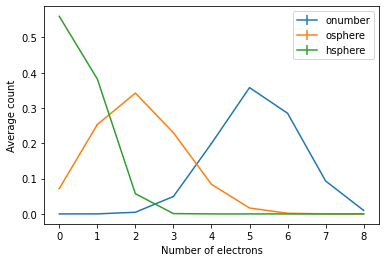

In [86]:
# Plot number distributions
import matplotlib.pyplot as plt
import h5py
import pyqmc

with h5py.File("h2o_vmc_numberacc.chk", "r") as hdf:
    d = {k: np.array(v) for k, v in hdf.items()}

warmup = 10
for label in ["onumber", "osphere", "hsphere"]:
    rb = pyqmc.reblock.reblock(d[label+"region"][warmup:], 20)
    avg = rb.mean(axis=0)
    err = rb.std(axis=0) / np.sqrt(len(rb) - 1)
    plt.errorbar(np.arange(len(avg)), avg, err, label=label)

plt.xlabel("Number of electrons")
plt.ylabel("Average count")
plt.legend()

## Evaluating specific configurations

If you're interested in seeing what the wave function or local quantities look like, it's easy to evaluate them on specific configurations.

default ion_cusp: ['H']


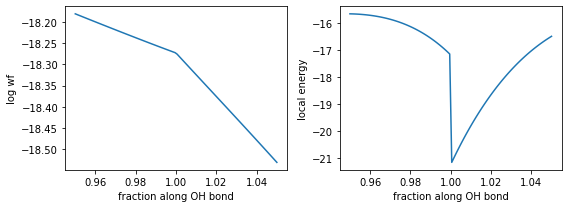

In [98]:
import pyqmc
import matplotlib.pyplot as plt

mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")

# Set up configs
nconf = 100
configs = pyqmc.initial_guess(mol, nconf)
configs.configs[:] = configs.configs[0]

Hcoord = mol.atom_coords()[1]
lineparam = np.linspace(0.95, 1.05, nconf)
configs.configs[:, 0, :] = np.outer(lineparam, Hcoord)

# Evaluate
wf, to_opt = pyqmc.default_sj(mol, mf, optimize_orbitals=True)
enacc = pyqmc.EnergyAccumulator(mol)
ph, val = wf.recompute(configs)
df = enacc(configs, wf)

# Plot
fig, axs= plt.subplots(1, 2, figsize=(8,3))
axs[0].plot(lineparam, val)
axs[0].set_ylabel("log wf")
axs[0].set_xlabel("fraction along OH bond")
axs[1].plot(lineparam, df["total"])
axs[1].set_ylabel("local energy")
axs[1].set_xlabel("fraction along OH bond")
plt.tight_layout()

## Excited determinant

Excited state properties have been calculated with DMC by using an excited determinant (or determinant expansion) as the trial function to determine the nodal surface. Such a trial function can be easily constructed, whether to use for DMC, or as a starting point for orthogonal optimization.

In [87]:
import pyqmc

mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")
mf.mo_occ[3] = 1 # decrease from 2 to 1
mf.mo_occ[4] = 1 # increase from 0 to 1

wf, to_opt = pyqmc.default_sj(mol, mf)


default ion_cusp: ['H']


## Multi-determinant wave function

For molecules, multi-determinant trial functions can be much better than single determinants. These can be generated from a PySCF CASCI object.

In [ ]:
from pyscf import mcscf
import pyqmc

mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")
mc = mcscf.CASCI(mf, ncas=8, nelecas=(4, 4))
mc.kernel()

wf, to_opt = pyqmc.default_msj(mol, mf, mc) # looks like kwarg optimize_orbitals is not up to date

## Periodic systems

Periodic calculations work similarly to molecules. In the PySCF calculation, we need to define a k-point grid.

In [ ]:
import pyscf
import pyqmc
import numpy as np


def run_si_scf(chkfile="si_scf.chk"):
    a = 5.43
    cell = gto.Cell(
        atom="Si 0. 0. 0.; Si {0} {0} {0}".format(a / 4), 
        unit="angstrom",
        basis="ccecp-ccpvtz",
        ecp="ccecp",
        a=(np.ones((3, 3)) - np.eye(3)) * a / 2,
    )   
    cell.exp_to_discard = 0.1 
    cell.build()

    kpts = cell.make_kpts([8, 8, 8]) 
    mf = scf.KRKS(cell, kpts=kpts)
    mf.chkfile = chkfile
    mf.run()

In QMC, we usually want to do the calculation on a supercell. Make sure that the SCF calculation included the k points corresponding to the supercell.

In this example, the conventional cell contains four of the kpoints contained in `[2, 2, 2]`, and double the conventional cell contains 32 of the kpoints contained in `[4, 4, 4]`. 

In [90]:
conventional_S = np.ones((3, 3)) - 2 * np.eye(3) # conventional cell for FCC
S = 2 * conventional_S
print("supercell matrix\n", S)

supercell matrix
 [[-2.  2.  2.]
 [ 2. -2.  2.]
 [ 2.  2. -2.]]


With 256 electrons, the distance matrix requires a lot of memory. The number of configurations can be reduced to compensate.

In [ ]:
if False:
    pyqmc.recipes.OPTIMIZE(chkfile, "si_opt.chk", S=S, nconfig=5)
    pyqmc.recipes.VMC(chkfile, "si_dmc.chk", start_from="si_opt.chk", S=S, nconfig=5, vmc_kws={"nblocks": 100})
    pyqmc.recipes.DMC(chkfile, "si_dmc.chk", start_from="si_opt.chk", S=S, nconfig=5)

In [ ]:
# without recipes
cell, mf = pyqmc.recover_pyscf("si_scf.chk")
supercell = pyqmc.get_supercell(cell, S)
# supercell is used in place of cell for all the pyqmc functions

## Running in parallel

Parallelization is handled by a "client" that gets passed to the various functions or recipes. Since PyQMC only deals with the client, it can be easily used with different parallelization libraries.

In [ ]:
# Using native python library
from concurrent.futures import ProcessPoolExecutor
import pyqmc

# with recipes
with ProcessPoolExecutor() as client:
    pyqmc.recipes.OPTIMIZE("h2o_scf.chk", "h2o_opt1.chk", client=client, npartitions=2)

# or calling functions directly
mol, mf = pyqmc.recover_pyscf("h2o_scf.chk")
wf, to_opt = pyqmc.default_sj(mol, mf)
pgrad = pyqmc.gradient_generator(mol, wf, to_opt)
pyqmc.line_minimization(wf, configs, pgrad, client=client, npartitions=2, hdf_file="h2o_opt1.chk")

### Using Dask

Dask uses "cluster" objects to manage the workers. The simplest for running on one node is LocalCluster


In [ ]:
# Using Dask LocalCluster
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2)

# For all dask clusters, running PyQMC is the same
with Client(cluster) as client:
    pyqmc.recipes.OPTIMIZE("h2o_scf.chk", "h2o_opt2.chk", client=client, npartitions=2)
cluster.close()

the LocalCluster from dask.distributed can be replaced by a different cluster object e.g. PBSCluster, SLURMCluster from dask_jobqueue, or a cluster for cloud computing, e.g. KubeCluster

In [ ]:
# Dask Kubernetes - taken from https://kubernetes.dask.org/en/latest/kubecluster.html#kubecluster
from dask_kubernetes import KubeCluster

cluster = KubeCluster.from_yaml('worker-spec.yml')
cluster.scale(10)  # specify number of workers explicitly
cluster.adapt(minimum=1, maximum=100)  # or dynamically scale based on current workload

# For all dask clusters, running PyQMC is the same
with Client(cluster) as client:
    pyqmc.recipes.OPTIMIZE("h2o_scf.chk", "h2o_opt3.chk", client=client, npartitions=2)
cluster.close()

### Using MPI for Python

MPI for Python is what it says. It has a futures object based on concurrent.futures that uses MPI, which is an alternative to Dask's MPI library for running on multiple nodes.

"The recommended way to execute the script is using the mpiexec command specifying one MPI process and (optional but recommended) the desired MPI universe size.

`mpiexec -n 1 -usize 17 python script.py`

Alternatively... all the MPI process are started at once. The user script is run under command line control of mpi4py.futures passing the -m flag to the python executable

`mpiexec -n 17 python -m mpi4py.futures script.py`

"- https://mpi4py.readthedocs.io/en/stable/mpi4py.futures.html


I have not tested it. But I imagine it works like this.

In [ ]:
# Taken from example at https://mpi4py.readthedocs.io/en/stable/mpi4py.futures.html
from mpi4py.futures import MPIPoolExecutor

with MPIPoolExecutor() as client:
    pyqmc.recipes.OPTIMIZE("h2o_scf.chk", "h2o_opt1.chk", client=client, npartitions=2)